In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%mathplotlib	inline

UsageError: Line magic function `%mathplotlib	inline` not found.


In [3]:
def f(x):
    return 3*x**2 - 4*x +5
f(3.0)

20.0

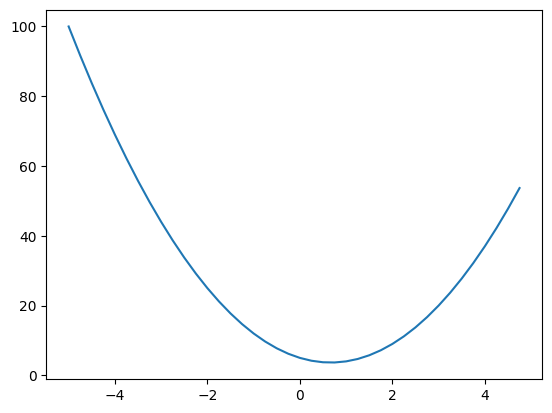

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00001
x =2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [6]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c +=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('Slope', (d2-d1)/h)

d1 4.0
d2 4.0001
Slope 0.9999999999976694


In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __pow__(self, other):
        assert isinstance(other,(int, float))
        out = Value( self.data**other, (self,), f'**{other}')
        def _backward():
            # n = other
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward=_backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L
T =L.tanh()
T.label = 'T'

In [8]:
from graphviz import Digraph
def trace(root):
    nodes, edges =set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape ='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh()
o.label = 'o'

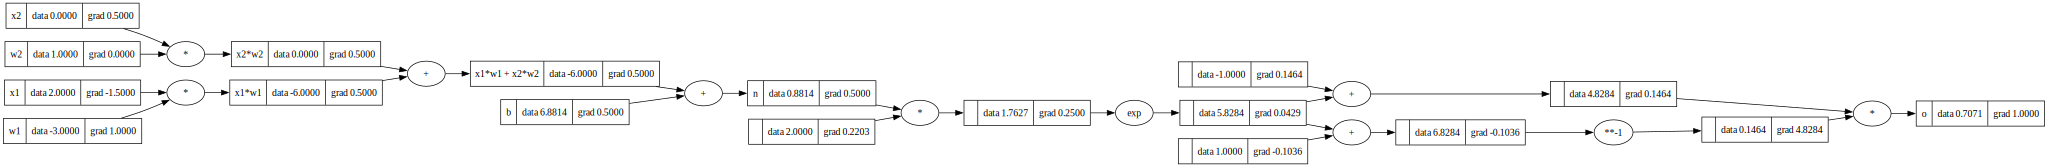

In [10]:
o.backward()
draw_dot(o)

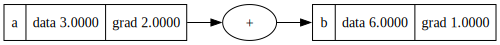

In [11]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)


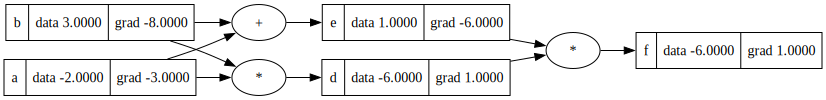

In [12]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dot(f)


In [13]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [14]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)
(n.parameters())
# draw_dot(n(x))

[Value(data=-0.09051799313955988),
 Value(data=-0.4238954086291673),
 Value(data=0.5047209737117306),
 Value(data=-0.27735345135698775),
 Value(data=-0.5271731487647635),
 Value(data=0.9024426421010838),
 Value(data=-0.34679127382310093),
 Value(data=-0.06624704614367083),
 Value(data=0.8720577305412969),
 Value(data=0.11734356846065741),
 Value(data=-0.9545690127959687),
 Value(data=0.28410335495317574),
 Value(data=0.07371473479703261),
 Value(data=-0.3217538645835527),
 Value(data=0.7487742276894829),
 Value(data=0.36445990965518216),
 Value(data=0.8803104518503677),
 Value(data=0.1047278208404252),
 Value(data=0.5285200447217209),
 Value(data=-0.6996900277157974),
 Value(data=0.2717202603590889),
 Value(data=-0.9791197562377674),
 Value(data=-0.7350024120991974),
 Value(data=-0.9104866980646134),
 Value(data=-0.025246440698764694),
 Value(data=-0.7473961686470505),
 Value(data=-0.9097072148768433),
 Value(data=-0.127274698750379),
 Value(data=0.9287273912331655),
 Value(data=-0.535

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# n = MLP(3, [4, 4, 1])
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.3577412677909917),
 Value(data=0.2521054609417585),
 Value(data=-0.37729673605962666),
 Value(data=0.2919041223096154)]

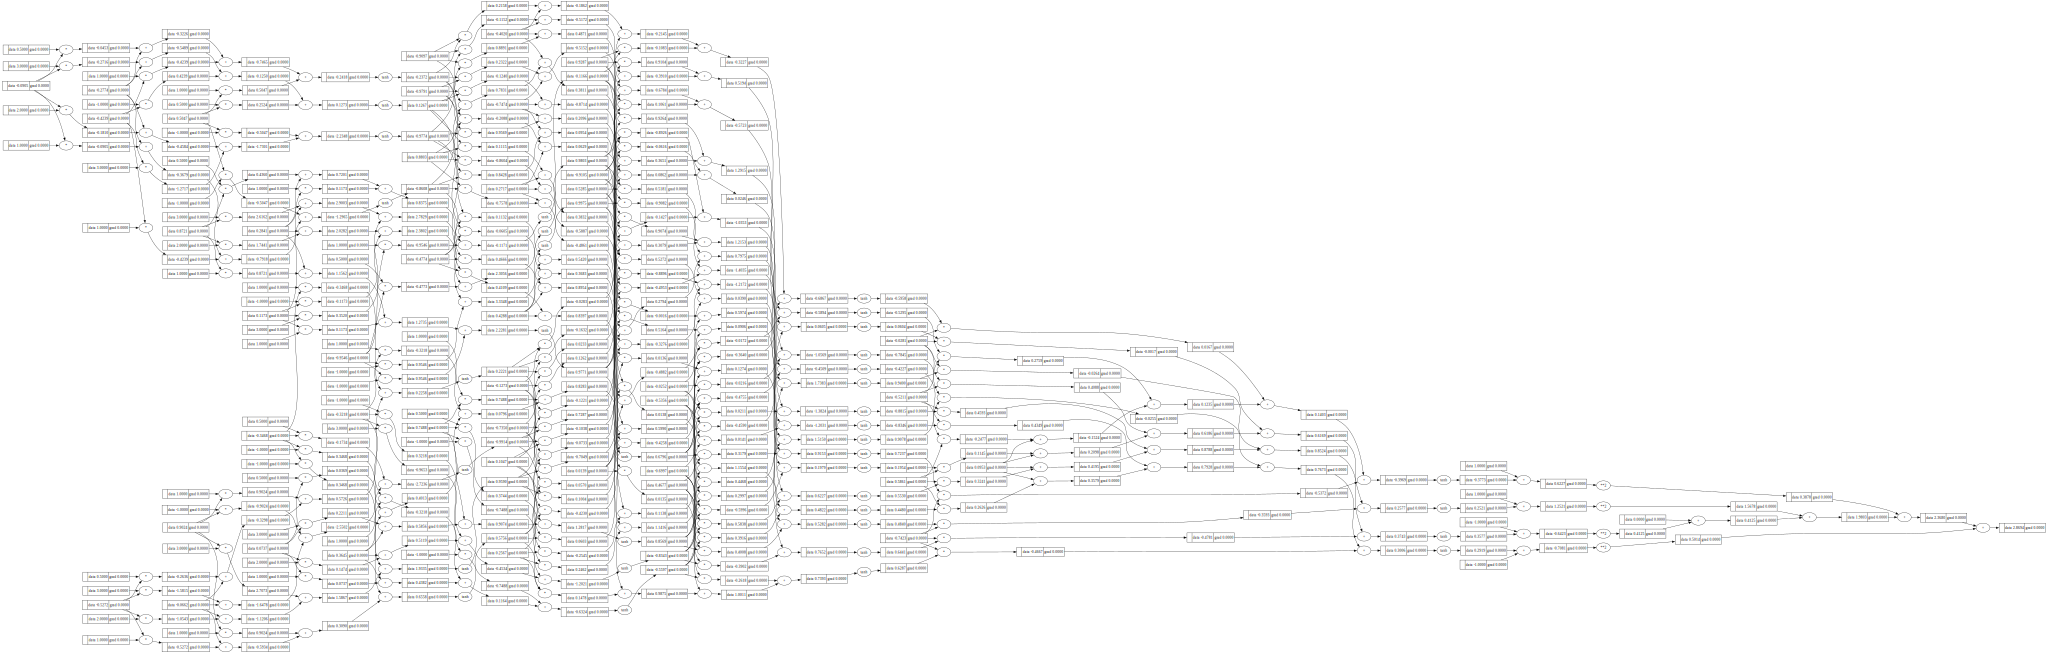

In [16]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss
draw_dot(loss)

In [17]:
ypred

[Value(data=0.3577412677909917),
 Value(data=0.2521054609417585),
 Value(data=-0.37729673605962666),
 Value(data=0.2919041223096154)]

In [18]:
loss.backward()


In [19]:
for p in n.parameters():
    p.data += -0.008 * p.grad


In [20]:

# draw_dot(loss)
n.layers[0].neurons[0].w[0].grad

7.007546698323901

In [21]:
for p in n.parameters():
    p.data += 0.1 * p.grad

In [22]:
n.layers[0].neurons[0].w[0].data

0.5541763031062391

In [23]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.869423491343007)

In [24]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

print(ypred)

0 8.222396618863225
1 7.674267654254637
2 7.253892990147949
3 6.890388086697811
4 6.536224049631283
5 6.164910074797309
6 5.767738218371328
7 5.3528478491589055
8 4.940292193614653
9 4.549782905530372
10 4.1891931739049255
11 3.853515644694248
12 3.53160283607995
13 3.2130027795851896
14 2.8922731572114255
15 2.571191416968872
16 2.2585334571047744
17 1.9666724988004312
18 1.7062498533680674
19 1.4823410143578497
20 1.2942588373053263
21 1.1378140766271976
22 1.0077075468381715
23 0.8989380687447512
24 0.8073166289522973
25 0.7295081151771527
26 0.662903708960445
27 0.6054656657998596
28 0.5555928077776615
29 0.5120158592816039
30 0.4737190671652135
31 0.4398820623620463
32 0.4098365902532294
33 0.3830340199398019
34 0.35902068324980463
35 0.3374189511375149
36 0.3179125619627861
37 0.30023513799062695
38 0.28416111957477735
39 0.2694985518243673
40 0.25608330410949565
41 0.24377440730050765
42 0.23245026969278873
43 0.22200558858017994
44 0.21234881614993356
45 0.2034000697457737
46 0